In [4]:
import os
import pandas as pd
import numpy as np
import seaborn as sns


In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm


In [6]:
# Set working directory
os.chdir('D:\\Assignments_SCMA632\\Data')
print(os.getcwd())

D:\Assignments_SCMA632\Data


In [7]:
# Load the data
df = pd.read_csv('NSSO68.csv',low_memory=False)

In [8]:
# Display column names
print(df.columns.tolist())


['slno', 'grp', 'Round_Centre', 'FSU_number', 'Round', 'Schedule_Number', 'Sample', 'Sector', 'state', 'State_Region', 'District', 'Stratum_Number', 'Sub_Stratum', 'Schedule_type', 'Sub_Round', 'Sub_Sample', 'FOD_Sub_Region', 'Hamlet_Group_Sub_Block', 't', 'X_Stage_Stratum', 'HHS_No', 'Level', 'Filler', 'hhdsz', 'NIC_2008', 'NCO_2004', 'HH_type', 'Religion', 'Social_Group', 'Whether_owns_any_land', 'Type_of_land_owned', 'Land_Owned', 'Land_Leased_in', 'Otherwise_possessed', 'Land_Leased_out', 'Land_Total_possessed', 'During_July_June_Cultivated', 'During_July_June_Irrigated', 'NSS', 'NSC', 'MLT', 'land_tt', 'Cooking_code', 'Lighting_code', 'Dwelling_unit_code', 'Regular_salary_earner', 'Perform_Ceremony', 'Meals_seved_to_non_hhld_members', 'Possess_ration_card', 'Type_of_ration_card', 'MPCE_URP', 'MPCE_MRP', 'Person_Srl_No', 'Relation', 'Sex', 'Age', 'Marital_Status', 'Education', 'Days_Stayed_away', 'No_of_Meals_per_day', 'Meals_School', 'Meals_Employer', 'Meals_Others', 'Meals_Paymen

In [9]:
# Filter for Punjab state
df_pun = df[df['state_1'] == 'Pun']

In [10]:
# Select relevant columns
vars = ["Sector", "hhdsz", "Religion", "Social_Group", "MPCE_URP", "Sex", "Age", "Marital_Status", "Education", "chicken_q", "chicken_v"]
df_pun_p = df_pun[vars]

In [12]:
# Create price variable
df_pun_p.loc[:, 'price'] = df_pun_p['chicken_v'] / df_pun_p['chicken_q']



In [16]:
# Replace NA values in price with 0 (if any)
df_pun_p.loc[:,'price'] = df_pun_p['price'].fillna(0)

In [17]:
# Summary of the DataFrame
print(df_pun_p.describe())

            Sector        hhdsz     Religion  Social_Group       MPCE_URP  \
count  3118.000000  3118.000000  3118.000000   3118.000000    3118.000000   
mean      1.502245     4.654586     2.570879      5.669019    2652.064452   
std       0.500075     2.204277     1.481989      3.382210    3059.678547   
min       1.000000     1.000000     1.000000      1.000000     485.000000   
25%       1.000000     3.000000     1.000000      2.000000    1428.487500   
50%       2.000000     4.000000     4.000000      9.000000    2052.915000   
75%       2.000000     6.000000     4.000000      9.000000    3050.427500   
max       2.000000    20.000000     9.000000      9.000000  119069.250000   

               Sex          Age  Marital_Status    Education    chicken_q  \
count  3118.000000  3118.000000     3118.000000  3118.000000  3118.000000   
mean      1.118345    47.778384        2.110006     5.897691     0.061360   
std       0.323068    14.126518        0.419017     3.578102     0.212437  

In [18]:
# Head of the table of chicken_q
print(df_pun_p['chicken_q'].value_counts().head())

chicken_q
0.000000    2689
0.250000      56
0.500000      47
0.333333      43
0.200000      37
Name: count, dtype: int64


In [19]:
# Dimensions of the DataFrame
print(df_pun_p.shape)


(3119, 12)


In [21]:
# Prepare data for the Tobit model
exog = df_pun_p[['hhdsz', 'Religion', 'MPCE_URP', 'Sex', 'Age', 'Marital_Status', 'Education', 'price']]
exog = sm.add_constant(exog)
endog = df_pun_p['chicken_q']


In [22]:
# Define the log-likelihood function
def tobit_loglike(params, exog, endog, left=0):
    beta = params[:-1]
    sigma = params[-1]
    XB = np.dot(exog, beta)
    z = (endog - XB) / sigma
    ll = np.where(endog > left,
                  np.log(norm.pdf(z) / sigma),
                  np.log(norm.cdf(z)))
    return -np.sum(ll)


In [23]:
# Initial parameters for optimization
initial_params = np.append(np.zeros(exog.shape[1]), 1)

In [26]:
from scipy.optimize import minimize
from scipy.stats import norm
# Fit the model using scipy.optimize.minimize
result = minimize(tobit_loglike, initial_params, args=(exog, endog), method='BFGS')
params = result.x


In [27]:
# Print the summary of the fitted model
print("Optimization successful:", result.success)
print("Estimated parameters:", params)
print("Log-likelihood:", -result.fun)

Optimization successful: False
Estimated parameters: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Log-likelihood: nan


In [28]:
# Exponentiate a coefficient
print(np.exp(-1.104))

0.3315422587848797


In [29]:
# Standard deviation of chicken_q
print(df_pun_p['chicken_q'].std())

0.21243688022595708


C:\Users\rache\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


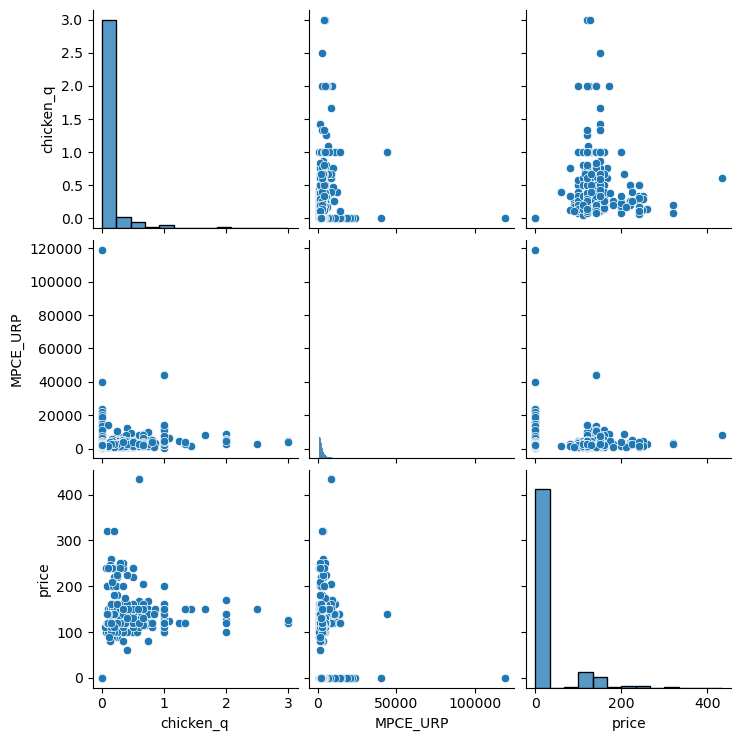

In [30]:
# Plot pairplot
sns.pairplot(df_pun_p[['chicken_q', 'MPCE_URP', 'price']])
plt.show()